In [1]:
! pip install nltk
! pip install tabulate


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Preparation of text corpora
This program is dedicated to the testing of pre-processing of the text corpora for the NER task, using an NLTK library and UDPipe tool.

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader

#first, we need to define the corpus from the Data folder
corpus = PlaintextCorpusReader('Data', '.*txt')

# some basic information on the corpus
words = corpus.words()
sentences = corpus.sents()

print(f"The number of text files in the corpus:",  len(corpus.fileids()))
print(f"The number of words in the corpus before pre-processing:", len(words))
print(f"The number of sentences in the corpus before pre-processing:", len(sentences))


The number of text files in the corpus: 95
The number of words in the corpus before pre-processing: 1763000
The number of sentences in the corpus before pre-processing: 151660


Next, size comparisons in between text files will be provided

In [3]:
# Some preparation first
#Remove 'Corpus/' from file ids
old_file_ids = corpus.fileids()
file_ids = [file_id.split('Corpus/')[1] for file_id in old_file_ids]
# Print the modified file ids
print(file_ids)


text_lengths = []  # list of word and sentence lengths for plotting
for file_id in corpus.fileids():
    words = corpus.words(fileids=[file_id])
    sentences = corpus.sents(fileids=[file_id])
    text_lengths.append((len(words), len(sentences)))  # appending the lengths of words and sentences to each file

print(text_lengths)

['1115688_Karla-Valguma-dienasgramatas.txt', '1115696_Edgara-Reinsona-dienasgramata.txt', '1117599_Irmas-Viksninas-dienasgramata.txt', '1117599_nezinamas-rigas-skolnieces-dienasgramata.txt', '1117608_Dainas-Rozenblates-Atminu-zimejumi.txt', '1119253_Adama-Purmala-dzivesstasts.txt', '1119255_Nezinama-cilveka-dzivesstasts-Sakts-1944-g-augusta.txt', '1120355_Jana-Pavasara-dzivesstasts.txt', '1122757_Kaspara-Tobja-dienasgramata.txt', '1133883_Augusta-Heinrihsona-dzivesstasts.txt', '1135456_Dzintara-Lazera-atminas.txt', '1135459_Paula-Alksna-pieraksti-un-darba-zurnali.txt', '1135846_Nezinama-viriesa-dienasgramata-ar-nosaukumu-Daba.txt', '1135955_Astridas-Tobes-celojumu-dienasgramatas.txt', '1146801_Ulda-Kirsa-dzive-laukos-Tvitera-dienasgramata.txt', '1146882_Otto-Viksnas-atminas.txt', '1165988_Alvila-Kalniesa-Klebaha-dienasgramatas.txt', '1172699_Jana-Valtera-Cokas-atminas.txt', '1172883_Jana-Golvera-atminas.txt', '1181543_Arvida-Feliksa-Latsona-dienasgramatas.txt', '1186759_Mirgas-Ivetas-K

In [4]:
import pandas as pd
from tabulate import tabulate

# Sorting files by text length
sorted_files = sorted(zip(file_ids, text_lengths), key=lambda x: x[1][0], reverse=True)
sorted_file_ids = [file_id for file_id, _ in sorted_files]
sorted_text_lengths = [words for _, words in sorted_files]

# Creation of a DataFrame from the sorted data
df = pd.DataFrame(sorted_files, columns=['File ID', 'Word Length'])

# Taking the first 10 largest and last 10 smallest texts
largest_texts = df.head(10)
largest_texts.index = largest_texts.index + 1  # Starting the numbering from 1
smallest_texts = df.tail(10)
smallest_texts.index = smallest_texts.index + 1  # Starting the numbering from 1

# Concatenation, tabulation and printing
merged_df = pd.concat([largest_texts, smallest_texts])

table_str = tabulate(merged_df, headers='keys', tablefmt='grid')

print(table_str)

+----+-----------------------------------------------------------------------+-----------------+
|    | File ID                                                               | Word Length     |
+====+=======================================================================+=================+
|  1 | 1165988_Alvila-Kalniesa-Klebaha-dienasgramatas.txt                    | (123847, 16998) |
+----+-----------------------------------------------------------------------+-----------------+
|  2 | 1410929_Ligitas-Vucenas-dienasgramatas.txt                            | (109955, 10611) |
+----+-----------------------------------------------------------------------+-----------------+
|  3 | 1636959_Rutas-Sleieres-dienasgramatas.txt                             | (93267, 8314)   |
+----+-----------------------------------------------------------------------+-----------------+
|  4 | 1633500_Marijas-Berzinas-atminas.txt                                  | (64215, 3406)   |
+----+------------------------

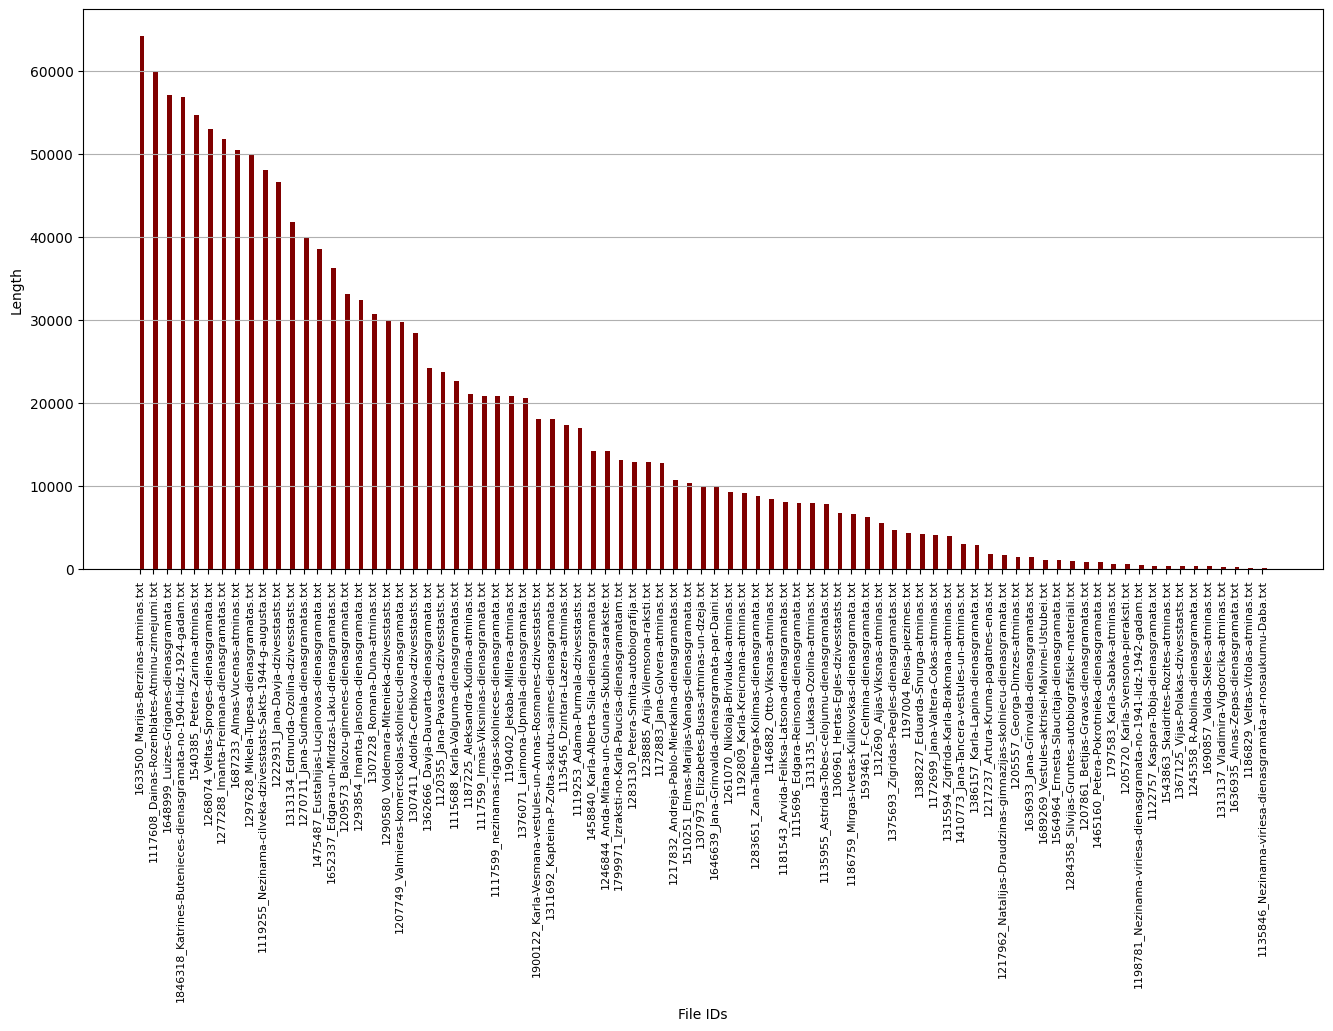

In [5]:
import matplotlib.pyplot as plt

# Since 3 largest and 9 smallest texts skew readability, they will be removed from the diagram
smaller_corpus = sorted_text_lengths[3:-9]
smaller_file_ids = sorted_file_ids[3:-9]

# Plotting of a bar diagram
plt.figure(figsize=(16, 8))  # Increase the height of the figure

bar_width = 0.35
index = range(len(smaller_corpus))

for i, words in enumerate(smaller_corpus): # Plotting the lengths of words
    plt.bar(index[i], words, bar_width, color='maroon', align='edge')

plt.xlabel('File IDs', fontsize=10)
plt.ylabel('Length')
plt.xticks(index, smaller_file_ids, rotation='vertical', fontsize=8)
plt.grid(axis='y')

plt.subplots_adjust(bottom=0.2, top=0.9) # Adjusting the position of the plot

plt.show()



Next, pre-processing of the corpus will commence. The approach is following the methodology of Laucis & Jēkabsons (2021)
The following steps will be taken:
* removal of BOM character
* removal of abbreviations with two or more capitalised letter sequences
* casefolding
* removing sequences between brackets
* separation of periods and commas followed by a space from a preceding word or number by a space
* all-but alpha-numeric characters, periods, commas, carriage returns, line feeds and spaces will be removed, 
* finally, corpus will be tokenized by splitting on whitespaces.

The result wil be saved in a new directory, keeping old file names.

In [6]:
import os
import re
from nltk.tokenize import word_tokenize

# Preprocessing function
def preprocess_text(text): 
    text = re.sub(r"\uFEFF", "", text) 

    text = re.sub(r"[A-Z]{2,}\b", "", text)

    text = text.lower()

    text = re.sub(r"\[[^\]]*\]", "", text)

    text = re.sub(r"([.,])\s", " ", text)
    
    text = re.sub(r"[^\w\d,. \r\n]", "", text)

    tokens = text.split()

    return tokens

# Preprocessing of the text
def preprocess_corpus(corpus): 
    new_corpus = [(file_id, preprocess_text(corpus.raw(file_id))) for file_id in corpus.fileids()]
    return new_corpus

new_corpus = preprocess_corpus(corpus)

# Saving of the preprocessed corpus
output_dir = 'Regular_Corpus'
os.makedirs(output_dir, exist_ok=True)

for file_id, tokens in new_corpus:
    output_filename = os.path.basename(file_id)  
    output_filepath = os.path.join(output_dir, output_filename)

    preprocessed_text = ' '.join(tokens)

    with open(output_filepath, 'w', encoding='utf-8') as file:
        file.write(preprocessed_text)

In [8]:
# some basic information on the corpus after pre-processing
regular_corpus = PlaintextCorpusReader('Regular_Corpus', '.*txt')
new_words = regular_corpus.words()
new_sentences = regular_corpus.sents()

print(f"The number of text files in the corpus:",  len(regular_corpus.fileids()))
print(f"The number of words in the corpus after pre-processing:", len(new_words))
print(f"The number of sentences in the corpus after pre-processing:", len(new_sentences))

The number of text files in the corpus: 95
The number of words in the corpus after pre-processing: 1408131
The number of sentences in the corpus after pre-processing: 2541


Next, a lemmatized corpus will be prepared with a UDPipe tool by Straka & Straková (2019), adapting the information from manual for the creation of corpus of lemmatized words. 
The model for processing Latvian text has to be pre-downloaded from the tool's repository at LINDAT. Here, model "latvian-lvtb-ud-2.5-191206.udpipe" was used. Direct aquisition from the relevant Github repository could be one of the improvements for future. 

In [10]:
! pip install ufal.udpipe

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/894.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/894.0 kB ? eta -:--:--
   - -------------------------------------- 30.7/894.0 kB 1.4 MB/s eta 0:00:01
   ---- ----------------------------------- 92.2/894.0 kB 1.3 MB/s eta 0:00:01
   ------ --------------------------------- 143.4/894.0 kB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 256.0/894.0 kB 2.0 MB/s eta 0:00:01
   --------------- ------------------------ 337.9/894.0 kB 1.9 MB/s eta 0:00:01
   ------------------ --------------------- 419.8/894.0 kB 2.0 MB/s eta 0:00:01
   ----------------------- ---------------- 532.5/894.0 kB 2.1 MB/s eta 0:00:01
   --------------------------- ------------ 604.2/894.0 kB 2.1 MB/s eta 0:00:01
   ------------------------------- -------- 706.6/894.0 kB 2.1 MB/s eta 0:00:01
   ----------------------------------- ---- 788.5/894.0 kB 2.2

In [14]:
import os
from ufal.udpipe import Model, Pipeline, ProcessingError

def run_udpipe(input_format, output_format, model_path, text):
    model = Model.load(model_path)
    if not model:
        raise ValueError(f"Cannot load model from file '{model_path}'")
    
    pipeline = Pipeline(model, input_format, Pipeline.DEFAULT, Pipeline.DEFAULT, output_format)
    error = ProcessingError()
    
    processed = pipeline.process(text, error)
    if error.occurred():
        raise RuntimeError("An error occurred when running run_udpipe: " + error.message)
    
    return processed

# Function to extract lemmatized forms from the output
def extract_lemmas(output_text):
    lemmas = []
    sentences = output_text.strip().split('\n\n')
    for sentence in sentences:
        for line in sentence.split('\n'):
            if line.startswith('#'):  # Skip comments
                continue
            if line == '':
                break
            parts = line.split('\t')
            lemmas.append(parts[2])  # Lemmatized form is the third element in the CoNLL-U format
    return lemmas

# Function to join the extracted lemmas back into one text
def join_lemmas(lemmas):
    return ' '.join(lemmas)

# Input and output directories
input_directory = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\Regular_Corpus"
output_directory = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\Lemmatized_Corpus"

# Checking for the directory
os.makedirs(output_directory, exist_ok=True)

# Path to the UDPipe model file
model_path = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\latvian-lvtb-ud-2.5-191206.udpipe"

# Loop for processing all files in the input directory, also coauning the number of saved files
num_saved_files = 0
for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):
        input_file = os.path.join(input_directory, filename)
        output_file = os.path.join(output_directory, "L_" + filename)  # Modified output filename for diferentiation
        
        with open(input_file, "r", encoding="utf-8") as file:
            input_text = file.read()
        
        try:
            output_text = run_udpipe("tokenize", "conllu", model_path, input_text)
            lemmas = extract_lemmas(output_text)
            joined_text = join_lemmas(lemmas)
            
            with open(output_file, "w", encoding="utf-8") as output_file:
                output_file.write(joined_text)
                
            num_saved_files += 1
        except Exception as e:
            print(f"Error processing file {input_file}: {e}")

# Print the count of saved files
print(f"Number of saved files in Lemmatized Corpus directory: {num_saved_files}")


Number of saved files in Lemmatized Corpus directory: 95


In [15]:
from nltk.corpus import PlaintextCorpusReader

# The previous approach to counting of tokens will be used
lemmatized_corpus = PlaintextCorpusReader('Lemmatized_Corpus', '.*txt')

lemmatized_words = lemmatized_corpus.words()

# Printing of the total number of tokens in the lemmatized corpus
tokens_lemmatized_corpus = len(lemmatized_words)
print(f"Total tokens in Lemmatized Corpus: {tokens_lemmatized_corpus}")

Total tokens in Lemmatized Corpus: 1409243


# References

* Laucis, R., & Jēkabsons, G. (2021). Evaluation of Word Embedding Models in Latvian NLP Tasks Based on Publicly Available Corpora. Applied Computer Systems, 26(2), 132–138. https://doi.org/10.2478/acss-2021-0016
* "UDPipe." (n.d.). Retrieved April 2024, from https://github.com/ufal/udpipe
* Straka, M., & Straková, J. (2019). Universal Dependencies 2.5 Models for UDPipe (2019-12-06). LINDAT/CLARIAH-CZ digital library at the Institute of Formal and Applied Linguistics (ÚFAL), Faculty of Mathematics and Physics, Charles University. http://hdl.handle.net/11234/1-3131